In [98]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# for modeling
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# Data Exploring in 'Breast_Cancer_Detection_EDA'

# Import Data in the same ways as explained in the EDA notebook

In [4]:
df = pd.read_csv('Breast-cancer-wisconsin.txt')

In [5]:
df

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
15850,15850,1169049,7,3,4,4,3,3,3,2,7,4
15851,15851,1076352,3,6,4,10,3,3,3,4,1,4
15852,15852,1107684,6,10,5,5,4,10,6,10,1,4
15853,15853,1111249,10,6,6,3,4,5,3,6,1,4


In [6]:
df['Class'].value_counts()

4          15164
2            456
40           151
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

In [7]:
df['Class'] = df['Class'].apply(lambda x: 0 if x=='2' else (1 if x=='4' else 2)).astype('int8')

In [8]:
target = 'Class'

In [9]:
df.drop(columns = 'Index',inplace = True)

In [50]:
# df.rename(columns = {'Class':'label'}, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           15855 non-null  int64 
 1   Clump Thickness              15855 non-null  int64 
 2   Uniformity of Cell Size      15827 non-null  object
 3   Uniformity of Cell Shape     15827 non-null  object
 4   Marginal Adhesion            15827 non-null  object
 5   Single Epithelial Cell Size  15827 non-null  object
 6   Bare Nuclei                  15827 non-null  object
 7   Bland Chromatin              15827 non-null  object
 8   Normal Nucleoli              15827 non-null  object
 9   Mitoses                      15827 non-null  object
 10  Class                        15855 non-null  int8  
dtypes: int64(2), int8(1), object(8)
memory usage: 1.2+ MB


In [20]:
df = pd.concat([df[['ID','Class']],df.drop(columns =['ID','Class'] )],axis = 1)

In [22]:
df['Class'].value_counts()

1    15164
0      456
2      235
Name: Class, dtype: int64

In [24]:
df = df[df['Class']!=2]

# Data preprocessing

## To get a baseline model, let's do basic data preprocessing

In [121]:
cols = list(df.columns)
cols

['ID',
 'Class',
 'Clump Thickness',
 'Uniformity of Cell Size',
 'Uniformity of Cell Shape',
 'Marginal Adhesion',
 'Single Epithelial Cell Size',
 'Bare Nuclei',
 'Bland Chromatin',
 'Normal Nucleoli',
 'Mitoses']

In [41]:
df[cols[7]].value_counts()

10    5106
8     3006
3     2019
5     2016
1     1394
2     1027
6     1000
4       19
?       16
9        9
7        8
Name: Bare Nuclei, dtype: int64

In [43]:
for col in cols[3:]:
    df[col] = df[col].apply(lambda x: int(x) if x.isnumeric() else None)

In [46]:
df.fillna(df.mean(),inplace = True)

In [49]:
for col in cols[1:]:
    df[col] = df[col].astype('int8')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15620 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   ID                           15620 non-null  int64
 1   Class                        15620 non-null  int8 
 2   Clump Thickness              15620 non-null  int8 
 3   Uniformity of Cell Size      15620 non-null  int8 
 4   Uniformity of Cell Shape     15620 non-null  int8 
 5   Marginal Adhesion            15620 non-null  int8 
 6   Single Epithelial Cell Size  15620 non-null  int8 
 7   Bare Nuclei                  15620 non-null  int8 
 8   Bland Chromatin              15620 non-null  int8 
 9   Normal Nucleoli              15620 non-null  int8 
 10  Mitoses                      15620 non-null  int8 
dtypes: int64(1), int8(10)
memory usage: 396.6 KB


In [51]:
df.shape

(15620, 11)

# Baseline Model

- ### I'll train with Random Forest Classifier and get a score using validation set (train:val = 0.7:0.3)

In [61]:
def make_train_val(df, val_size = 0.3):
    # Split the data into training and testing sets
    train, val = train_test_split(df, test_size = val_size)
    assert train.shape[0]+val.shape[0] == df.shape[0], 'data wrong'
    assert train.shape[1] == val.shape[1], 'data wrong'
    return train, val

def make_XY(df, target, drop_cols = []):
    dataX, dataY = df.drop([target]+drop_cols, axis=1), df[target]
    return dataX, dataY

In [62]:
target = 'Class'
train, val = make_train_val(df)
trainX, trainY = make_XY(train,target)
valX, valY = make_XY(val,target)
del train, val

In [63]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 10,  max_depth=5, n_jobs=-1)
# Train with the training data
random_forest.fit(trainX, trainY)

RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1)

In [102]:
# Function showing scores of the model on a validation set
model = random_forest
predProba = model.predict_proba(valX)
# Make predictions on the validation data
pred = model.predict(valX)

## Accuracy:
print("accuracy: ", accuracy_score(pred, valY))

# compute the AUC score:
auc_score = roc_auc_score(valY, predProba[:,1])
print("AUC score: ", auc_score)

# confusion matrix:
print("confusion matrix:\n", confusion_matrix(pred, valY),"\n")


accuracy:  0.9980793854033291
AUC score:  0.9999307759843317
confusion matrix:
 [[ 127    6]
 [   3 4550]] 



In [103]:
misclass = valX[valY != pred]

In [104]:
misclass['true'] = valY[valY != pred]
misclass['pred'] = pred[valY != pred]

In [79]:
misclass

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,true,pred
1765,721482,4,4,4,4,6,5,7,3,1,0,1
1399,188336,5,3,2,8,5,10,8,1,2,1,0
4248,1084139,6,3,2,1,3,4,4,1,1,1,0
8590,1065726,5,2,3,4,2,7,3,6,1,1,0
10011,1173347,8,3,3,1,2,2,3,2,1,0,1
15717,752904,10,1,1,1,2,10,5,4,1,1,0
15140,543558,6,1,3,1,4,5,5,10,1,1,0
15756,1016277,6,8,8,1,3,4,3,7,1,0,1
13718,1177399,8,3,5,4,5,10,1,6,2,1,0


In [ ]:
# Function showing scores of the model on a validation set
def output_auc(model, data_X, data_Y, return_auc=False):
    ## Results on val data:
    predProba = model.predict_proba(data_X)
    # Make predictions on the validation data
    pred = model.predict(data_X)

    ## Accuracy:
    print("accuracy: ", accuracy_score(pred, data_Y))

    # compute the AUC score:
    auc_score = roc_auc_score(data_Y, predProba[:,1])
    print("AUC score: ", auc_score)

    # confusion matrix:
    print("confusion matrix:\n", confusion_matrix(pred, data_Y),"\n")
        
    if return_auc:
        return auc_score

- ### Random Forest already works so good.

# LightGBM

In [193]:
rs = ShuffleSplit(n_splits=1, test_size=.30)

In [194]:
lgb_clf = lgb.LGBMClassifier(num_leaves = 100, n_estimators=100,
                        n_jobs=-1,
                        max_depth=5,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        min_data_in_leaf = 0,
                        min_split_gain = 0,
                        subsample_for_bin = 200000)

In [195]:
def lgb_training(df1, target = 'Class'):
    df1X = df1.drop(target, axis=1)
    feature_names = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in list(df1X.columns)]
    for train_index, val_index in rs.split(df1, df1[target]):
        trainX, trainY = df1X.iloc[train_index], df1[target].iloc[train_index]

    #     trainY.reset_index(drop = True, inplace = True)
    #     trainX.reset_index(drop = True, inplace = True)
    #     idx_for_1 = np.where(trainY == 1)[0]
    #     idx_for_0 = list(  set(range(trainY.shape[0]))-set(idx_for_1)  )
    #     sample_idx_for_0 = random.choices(idx_for_0,k = (trainY == 1).sum())
    #     sample_idx = list(idx_for_1) + sample_idx_for_0
    #     sample_idx.sort()

    #     trainX = trainX.iloc[sample_idx]
    #     trainY = trainY.iloc[sample_idx]

        valX, valY = df1X.iloc[val_index], df1[target].iloc[val_index]
        lgb_clf.fit(trainX, trainY, feature_name = feature_names)
        output_auc(lgb_clf, valX, valY)

In [196]:
lgb_training(df)

accuracy:  0.9978659837814767
AUC score:  0.9996632822213013
confusion matrix:
 [[ 109    5]
 [   5 4567]] 



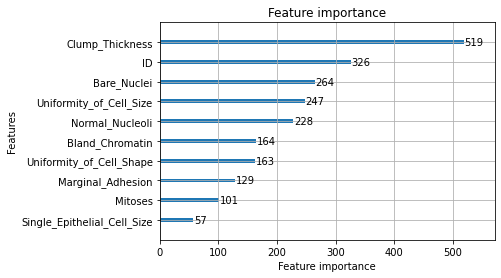

In [85]:
lgb.plot_importance(lgb_clf,max_num_features=20 , importance_type = 'split')

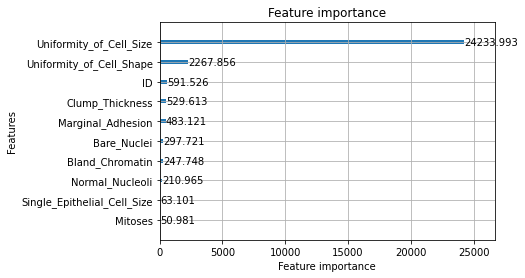

In [86]:
lgb.plot_importance(lgb_clf,max_num_features=20 , importance_type = 'gain')

In [197]:
model = lgb_clf
predProba = model.predict_proba(valX)
# Make predictions on the validation data
pred = model.predict(valX)

## Accuracy:
print("accuracy: ", accuracy_score(pred, valY))

# compute the AUC score:
auc_score = roc_auc_score(valY, predProba[:,1])
print("AUC score: ", auc_score)

# confusion matrix:
print("confusion matrix:\n", confusion_matrix(pred, valY),"\n")


accuracy:  0.9991463935125907
AUC score:  0.9999881812656176
confusion matrix:
 [[ 129    3]
 [   1 4553]] 



In [203]:
# from sklearn.externals import joblib
import joblib
# save model
joblib.dump(lgb_clf, 'lgb.pkl')
# load model
gbm_pickle = joblib.load('lgb.pkl')

In [208]:
model = gbm_pickle
predProba = model.predict_proba(valX)
# Make predictions on the validation data
pred = model.predict(valX)

## Accuracy:
print("accuracy: ", accuracy_score(pred, valY))

# compute the AUC score:
auc_score = roc_auc_score(valY, predProba[:,1])
print("AUC score: ", auc_score)

# confusion matrix:
print("confusion matrix:\n", confusion_matrix(pred, valY),"\n")


accuracy:  0.9991463935125907
AUC score:  0.9999881812656176
confusion matrix:
 [[ 129    3]
 [   1 4553]] 



## Let's explore misclassified examples

In [107]:
misclass = valX[valY != pred]

In [110]:
misclass['Class'] = valY[valY != pred]
misclass['pred'] = pred[valY != pred]

In [113]:
misclass

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,pred,Class
1765,721482,4,4,4,4,6,5,7,3,1,1,0
4248,1084139,6,3,2,1,3,4,4,1,1,0,1
10011,1173347,8,3,3,1,2,2,3,2,1,1,0
10343,1257648,4,3,3,1,2,1,3,3,1,1,0
15756,1016277,6,8,8,1,3,4,3,7,1,1,0
5636,859164,5,3,3,1,3,3,3,3,3,0,1


In [152]:
# Function to plot the statistics for categorical data
def bar_plot(df, feature, target = target, fill_na = 'null', others_threshold = -1, 
             target_plots =True, xtick_rotate = False, reduced = False, box_plot = False, sorted_plot_order = False, missclass = False):
#     if sorted_plot_order:
#         assert (type(fill_na) == np.int)|(type(fill_na) == np.float), 'fill_na should be number for sorted_plot_order'
    y_label = 'Malignant'
    total_num = len(df)
    if feature != target:
        df_trans = df[[target, feature]].copy()
        if fill_na is not None:
            df_trans[feature] = df_trans[feature].fillna(fill_na)

            
        df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
                    [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
                     , feature] = "others"
    

        tmp = pd.crosstab(df_trans[feature], df_trans[target], normalize='index') * 100
        tmp.reset_index(inplace = True)
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    
    elif feature == target:
        target_plots = False
        df_trans = df[[feature]].copy()
    

    if sorted_plot_order:
        str_val = []
        num_val = []
        for value in df_trans[feature].unique():
            if type(value) == np.str:
                str_val.append(value)
            else:
                num_val.append(value)
        plot_order = list(np.sort(str_val))+list(np.sort(num_val))
    else:
        plot_order = df_trans[feature].value_counts().keys()
      
                
    plt.figure(figsize=(14,13))
    if target_plots & (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    if missclass:
        plt.suptitle(f'(missclass) {feature} Distributions', fontsize=22, y=title_y)
    else:
        plt.suptitle(f'(df) {feature} Distributions', fontsize=22, y=title_y)
        
    plt.subplot(321)
    g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
    heights = []
    for p in g.patches:
        height = p.get_height()
        heights.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + min(3,height*0.01),
                '{:1.2f}%'.format(height/total_num*100),
                ha="center", fontsize=14)
    g.set_ylim(0, max(heights) *1.1 )

    if (target_plots) & (not reduced):
        plt.subplot(322)
        g2 = sns.countplot(x=feature, hue=target, data=df_trans, order = plot_order)

        g2_pt = g2.twinx()
        g2_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g2_pt.set_ylabel(f"% of {y_label} (Counts)", fontsize=16)

        g2.set_title(f"Frequency by Target({target})", fontsize=19)
        g2.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha="right")
        g2.set_ylabel("Count", fontsize=17)

    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()



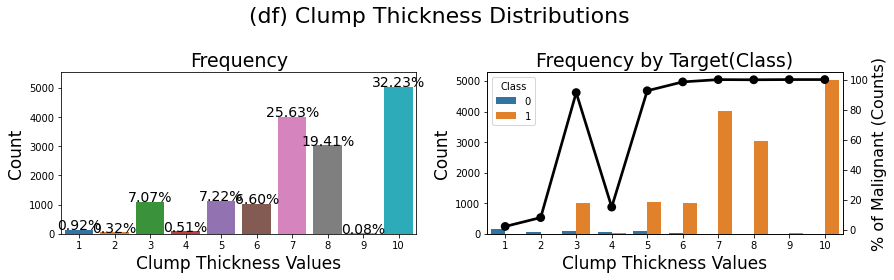

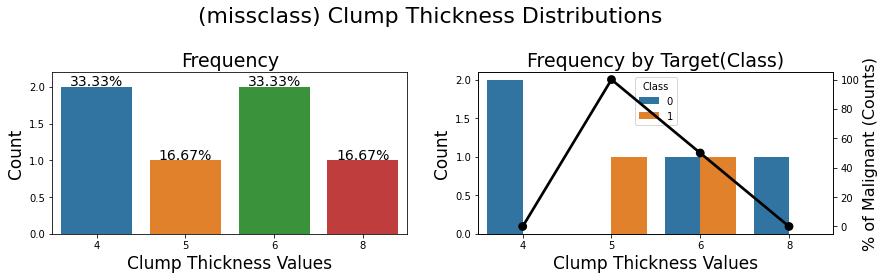

In [153]:
col = cols[2]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

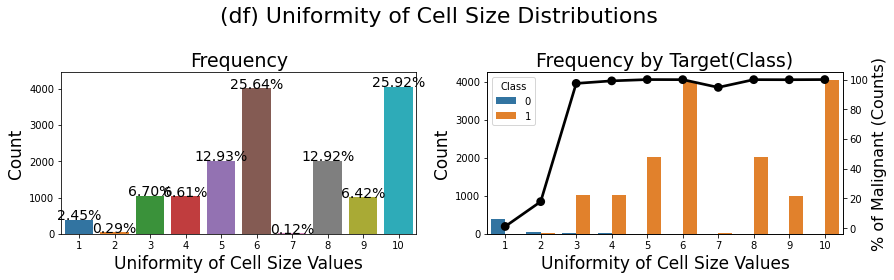

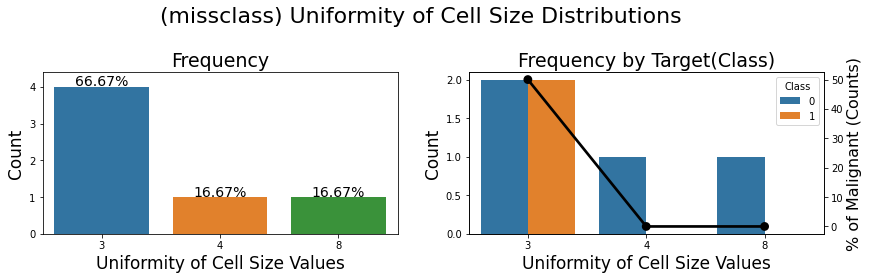

In [154]:
col = cols[3]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

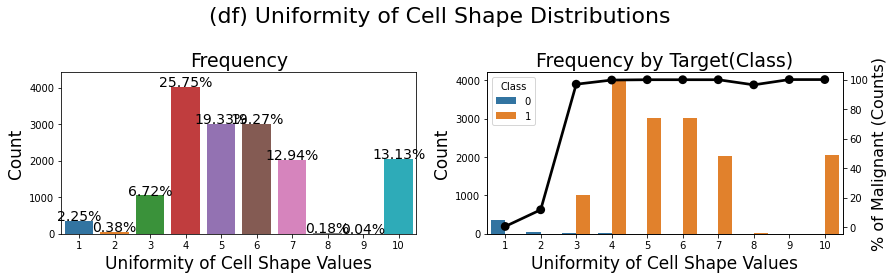

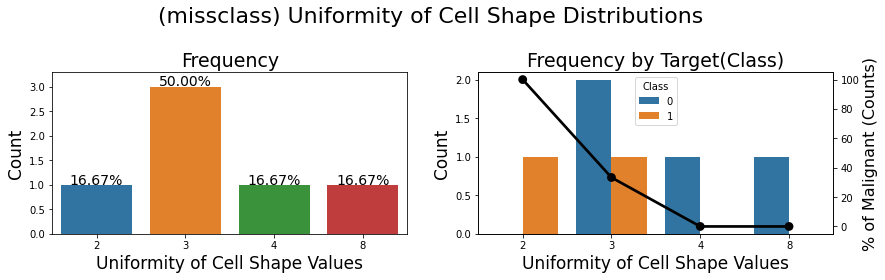

In [155]:
col = cols[4]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

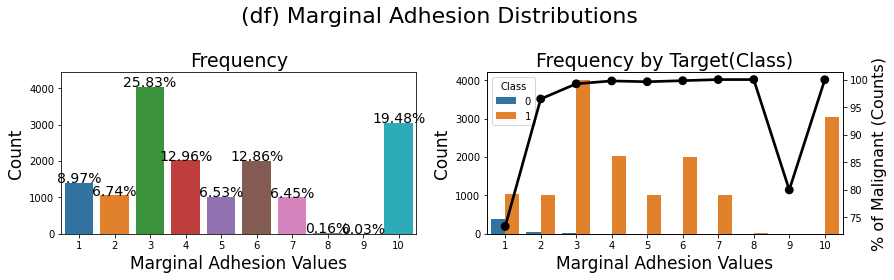

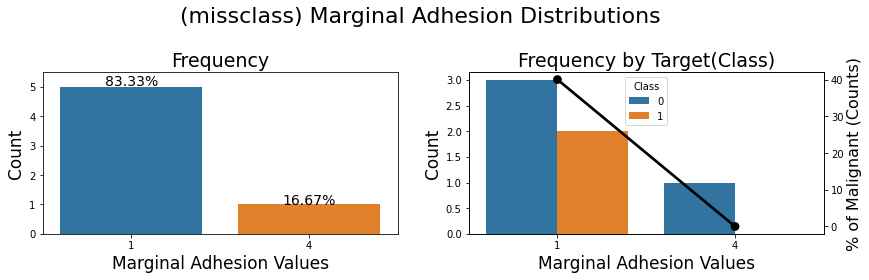

In [156]:
col = cols[5]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

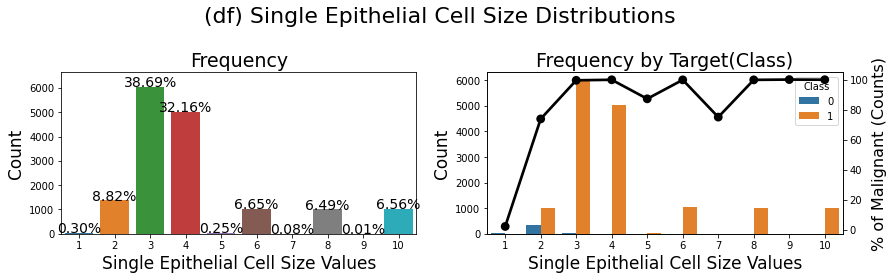

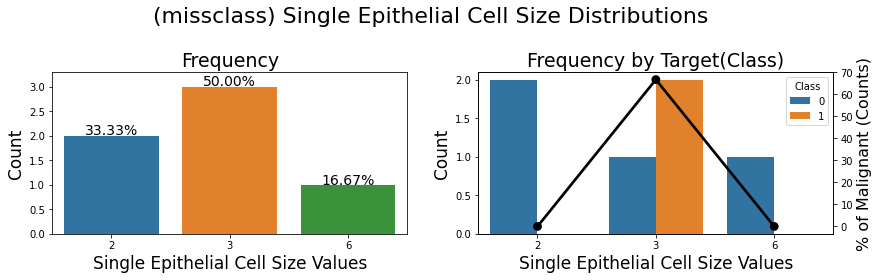

In [157]:
col = cols[6]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

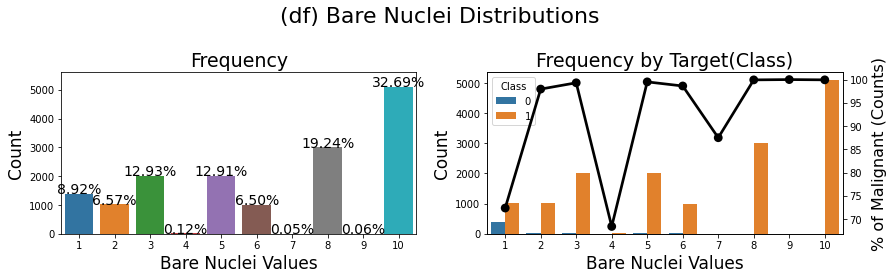

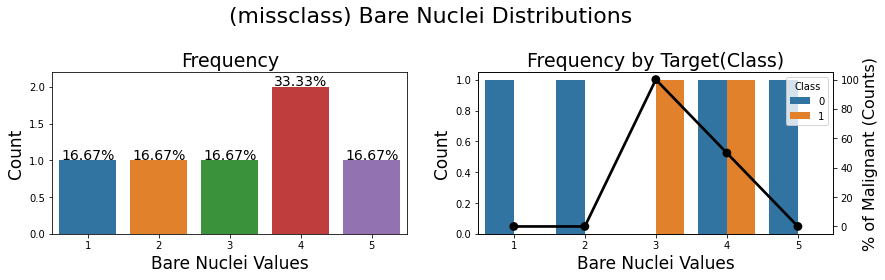

In [158]:
col = cols[7]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

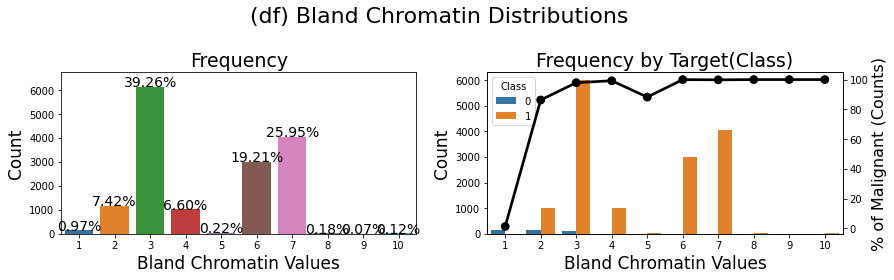

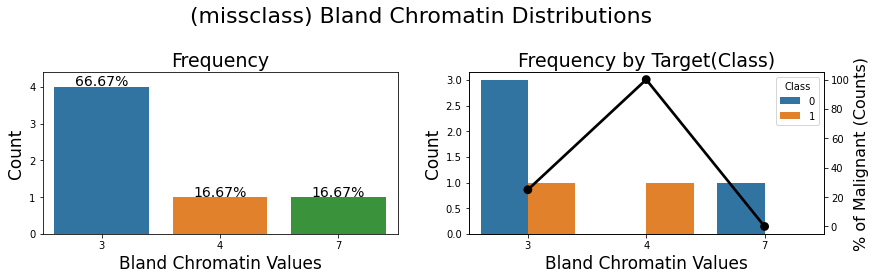

In [159]:
col = cols[8]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

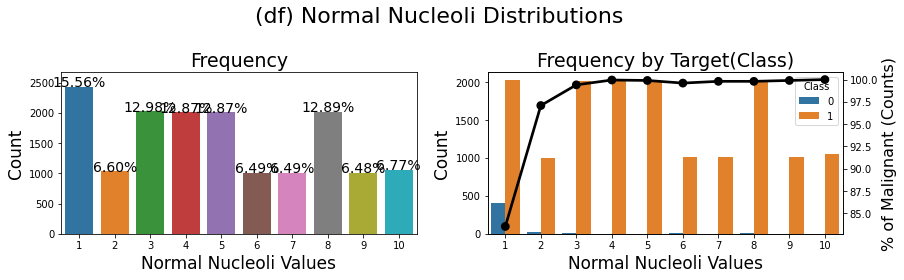

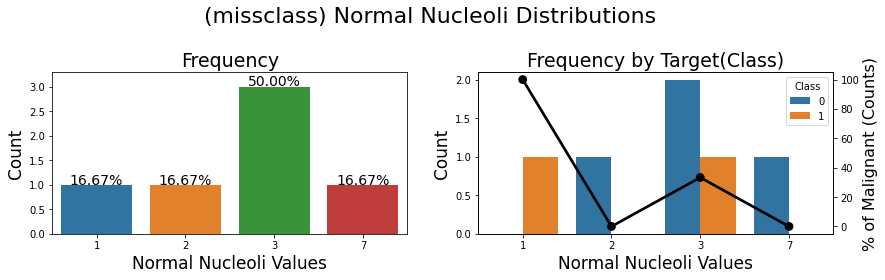

In [160]:
col = cols[9]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)

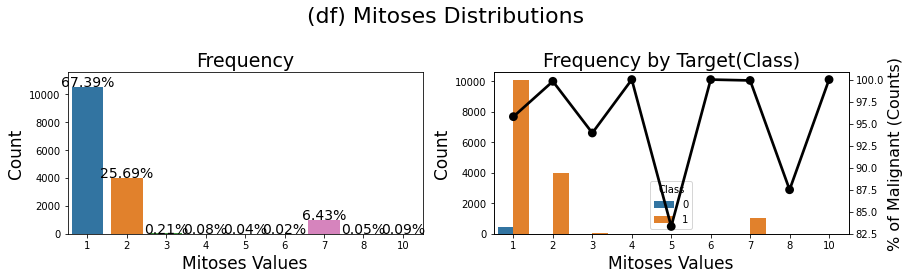

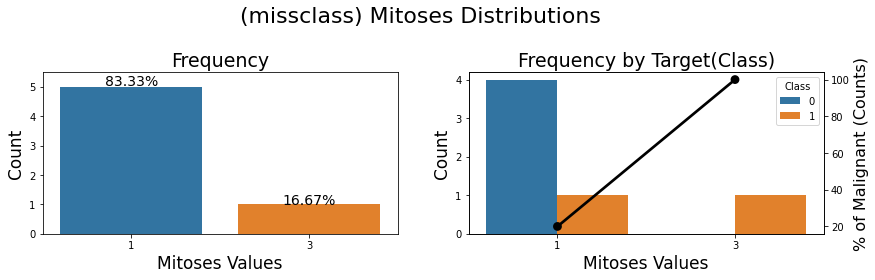

In [161]:
col = cols[10]
bar_plot(df, col, sorted_plot_order=True)
bar_plot(misclass,col, missclass=True, sorted_plot_order=True)